In [2]:
import os
import ot
import PIL
import glob
import torch
import random
import imageio
import numpy as np
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torchvision import datasets, transforms

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
!mkdir ./Results
!mkdir ./Results/DCGAN

--2021-04-13 21:34:39--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-13 21:34:40--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  20.4MB/s    in 1.6s    

2021-04-13 21:34:42 (20.4 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [5]:
def get_data_loader(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))
        transforms.Normalize((0.5, ), (0.5, ))
    ])

    train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)

    # Data Loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

In [6]:
def generate_samples(netG, noise, epoch=0, close=False):
    with torch.no_grad():
        generated = netG(noise).detach()

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(
        np.transpose(vutils.make_grid(generated[:64], padding=2, normalize=True).cpu(),(1,2,0))
    )
    plt.savefig('./Results/DCGAN/epoch{}.png'.format(epoch))
    if close: plt.close('all')
    
    return generated

In [7]:
def wdist(x, y, a=None, b=None, eps=0.0, metric='cityblock'):
    a = ot.unif(x.shape[0]) if a is None else a
    b = ot.unif(y.shape[0]) if b is None else b
    M = ot.dist(x, y, metric=metric)

    if eps > 0.0:
        G = ot.sinkhorn(a, b, M, reg=eps)
    else:
        G = ot.emd(a, b, M)

    return np.sum(G * M)

In [8]:
dataloader = get_data_loader(batch_size)

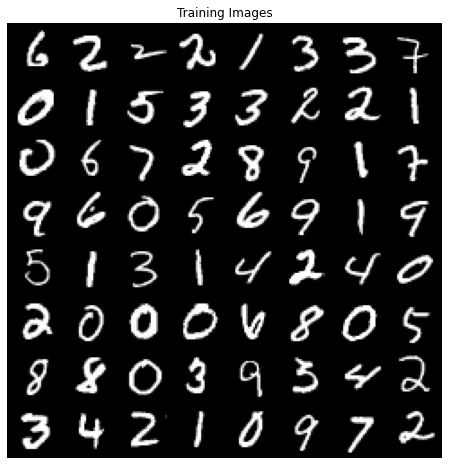

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))
)

In [10]:
print(real_batch[0].min(), real_batch[0].max())

tensor(-1.) tensor(1.)


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
  
    def forward(self, x):
        output = self.network(x)
        return output

In [13]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.network(x)
        return output.view(-1, 1).squeeze(1)

In [14]:
netG = Generator(nc=1, nz=100, ngf=28).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 112, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(112, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(56, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [15]:
netD = Discriminator(nc=1, ndf=28).to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(112, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


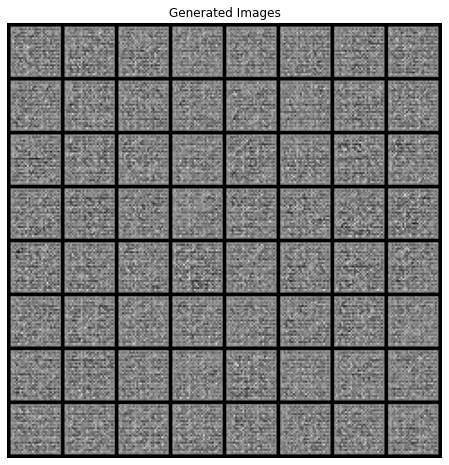

In [16]:
fixed_noise = torch.randn(batch_size, 100, 1, 1, device=device)
fake_samples = generate_samples(netG, fixed_noise)

In [17]:
x = fake_samples.detach().cpu().numpy().reshape(batch_size, -1)
y = real_batch[0].detach().cpu().numpy().reshape(batch_size, -1)
print(wdist(x, y))

684.1192917918092


In [18]:
real_label = 1
fake_label = 0

num_batches = len(dataloader)

In [19]:
# Loss Function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=2e-4)
optimizerG = optim.Adam(netG.parameters(), lr=2e-4)

In [20]:
history = {
    'lossD': [],
    'lossG': [],
    'Wdist': []
}

In [21]:
print("-" * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|{:^25}|".format("Epoch", "LossD", "LossG", "Wdist"))
for epoch in range(100):
    epoch_lossD = 0
    epoch_lossG = 0
    wass_loss = 0
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.shape[0]
        # --------------------------
        # | Training discriminator |
        # --------------------------
        
        # Zero the accumulated gradients
        netD.zero_grad()
        
        # move data to device (possibly GPU)
        real_images = real_images.to(device)
        
        # Labels the data
        label = torch.full((batch_size,), real_label, device=device)
        
        # Feedforward
        output = netD(real_images)
        
        # Discriminator loss
        lossD_real = criterion(output, label.float())
        
        # Calculates Gradients
        lossD_real.backward()
        
        # predictions
        # D_x = output.mean().item()
        
        # Create noise vector for generator
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        
        # Generates fake images
        fake_images = netG(noise)
        
        # fill vector with fake labels
        label.fill_(fake_label)
        
        # Pass fake images through discriminator
        output = netD(fake_images.detach())
        
        # Calculates loss on fake samples
        lossD_fake = criterion(output, label.float())
        
        # Calculates Gradients
        lossD_fake.backward()
        
        # predictions
        # D_G_z1 = output.mean().item()
        
        # Calculates total loss
        lossD = lossD_real + lossD_fake
        epoch_lossD += lossD / len(dataloader)
        
        # Backpropagation / Optimization Step
        optimizerD.step()
        
        # ----------------------
        # | Training generator |
        # ----------------------
        
        # Zero the accumulated gradients
        netG.zero_grad()
        
        # Fills label vec
        label.fill_(real_label)
        
        # Pass fake images through discriminator
        output = netD(fake_images)
        
        # Calculates generator loss
        lossG = criterion(output, label.float())
        epoch_lossG += lossG / len(dataloader)
        
        # Calculates gradients
        lossG.backward()
        
        # predictions
        # D_G_z2 = output.mean().item()
        
        # Backpropagation
        optimizerG.step()

        # Computes Wdist
        x = fake_images.detach().cpu().numpy().reshape(batch_size, -1)
        y = real_images.detach().cpu().numpy().reshape(batch_size, -1)
        wass_loss += wdist(x, y)
    # Write on history
    generate_samples(netG, fixed_noise, epoch=epoch + 1, close=True)
    history['lossD'].append(epoch_lossD)
    history['lossG'].append(epoch_lossG)
    history['Wdist'].append(wass_loss)
    print("|{:^12}/{:^12}|{:^25}|{:^25}|{:^25}|".format(epoch, 100, epoch_lossD, epoch_lossG, wass_loss))
print("-" * (26 * 3 + 1))

-------------------------------------------------------------------------------
|          Epoch          |          LossD          |          LossG          |          Wdist          |
|     0      /    100     |   0.08845946937799454   |    4.933942794799805    |    280919.9970187627    |
|     1      /    100     |   0.01654728129506111   |    6.602901458740234    |   211923.10914009134    |
|     2      /    100     |  0.043475646525621414   |    6.538447856903076    |    168654.0341673827    |
|     3      /    100     |  0.017456084489822388   |    6.383098602294922    |    134801.6437342713    |
|     4      /    100     |   0.09475546330213547   |    6.080654621124268    |   123497.12208249651    |
|     5      /    100     |  0.034358467906713486   |    5.795713424682617    |   109896.33812671878    |
|     6      /    100     |   0.02972419746220112   |    5.904189109802246    |    93403.81234487172    |
|     7      /    100     |   0.07653876394033432   |    5.6036610603332

In [22]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = ['./Results/DCGAN/epoch{}.png'.format(i) for i in range(100)]
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

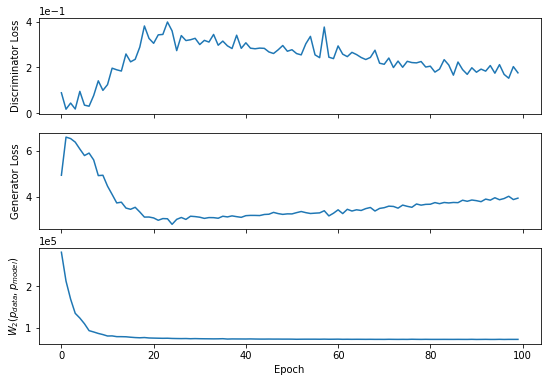

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axes[0].plot(history['lossD'])
axes[0].set_ylabel('Discriminator Loss')
axes[0].ticklabel_format(style='sci')
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axes[1].plot(history['lossG'])
axes[1].set_ylabel('Generator Loss')
axes[1].ticklabel_format(style='sci')
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axes[2].plot(history['Wdist'])
axes[2].set_ylabel('$W_{2}(p_{data}, p_{model})$')
axes[2].set_xlabel('Epoch')
axes[2].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.savefig('./Results/dcgan_train.png')